In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
import emcee
import sys
import numpy as np
import corner
from astropy.table import Table

sys.path.append('../modules/')
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_fit_cluster_mass as fit
import CL_Likelihood_for_Mass_richness_relation as mr
import analysis_Mass_Richness_relation as analysis
import CL_fiducial_mass_richness_relation as fiducial

In [2]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

# Load data

In [3]:
ind_profile = np.load('../data/data_new_version/ind_profile_redmapper.pkl', allow_pickle = True)
ind_profile['cluster_id'] = ind_profile['id']

In [4]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

# WL mass

## Estimating shear profile

In [5]:
profile_true_stack = prf.stacked_profile(profile = ind_profile,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)
covariance_true_stack = prf.bootstrap_covariance(profile = ind_profile,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [6]:
profile_BPZ_stack = prf.stacked_profile(profile = ind_profile,
 r_in = 'radius_bpz',
                    gt_in = 'DSt_bpz', gx_in = 'DSx_bpz',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_bpz',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)
covariance_BPZ_stack = prf.bootstrap_covariance(profile = ind_profile,
                    r_in = 'radius_bpz',
                    gt_in = 'DSt_bpz', gx_in = 'DSx_bpz',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_bpz',
                    n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [7]:
profile_flex_stack = prf.stacked_profile(profile = ind_profile,
 r_in = 'radius_flex',
                    gt_in = 'DSt_flex', gx_in = 'DSx_flex',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_flex',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

covariance_flex_stack = prf.bootstrap_covariance(profile = ind_profile,
                    r_in = 'radius_flex',
                    gt_in = 'DSt_flex', gx_in = 'DSx_flex',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_flex',
                    n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

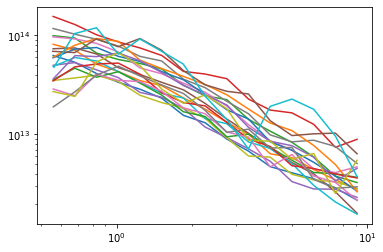

In [8]:
for p in profile_true_stack:
    plt.loglog(p['radius'], p['gt'])

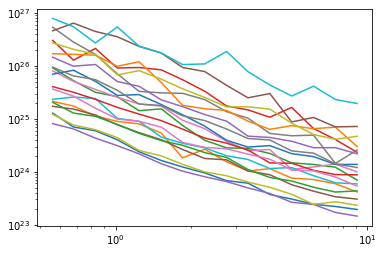

In [9]:
for c in covariance_true_stack:
    plt.loglog(p['radius'], c['cov_t'].diagonal())

## Fit halo mass

In [10]:
true = fit.fit_WL_cluster_mass(profile = profile_true_stack, covariance = covariance_true_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False,halo_model = 'nfw')
BPZ =  fit.fit_WL_cluster_mass(profile = profile_BPZ_stack,  covariance = covariance_BPZ_stack,  a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False,halo_model = 'nfw')
flex = fit.fit_WL_cluster_mass(profile = profile_flex_stack, covariance = covariance_flex_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False,halo_model = 'nfw')

fitting...
fitting...
fitting...


In [11]:
fits = [true, BPZ, flex]

Text(0, 0.5, '$\\log_{10}(M_{\\rm 200c}^{\\rm WL}/M_{\\odot})$')

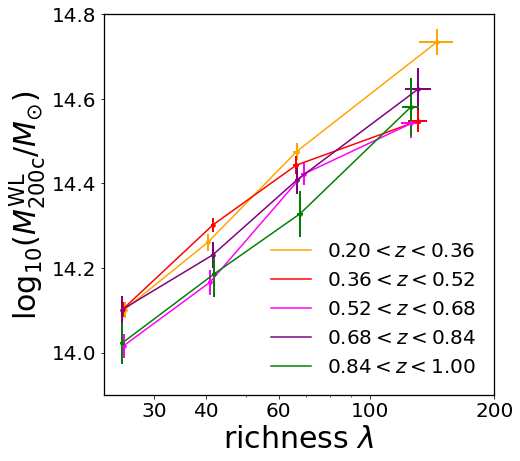

In [24]:
import matplotlib.ticker
fig, ax  = plt.subplots(figsize = (7,7))
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
x = np.linspace(1,3,100)
f = true
for k, z_bin in enumerate(Z_bin):
        f = Table(f)
        plt.plot([],[], '-', c = color_z[k],label = f'{z_bin[0]:.2f}'+ r'$< z < $'+ f'{z_bin[1]:.2f}',)
        mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
        f_cut = f[mask]
        a_t = 1./(1 + f_cut['z_mean'])
        richness = f_cut['obs_mean']
        richness_err = f_cut['obs_rms']
        logm200w = f_cut['logm200_w']
        logm200w_err = f_cut['logm200_w_err']
        ax.errorbar(richness,logm200w,logm200w_err, richness_err,
                    marker = '.', fmt = '-',
                    elinewidth = 2, capsize = 0, markersize = 7, c = color_z[k],
                        markerfacecolor = None)

ax.set_ylim(13.9,14.8)
ax.set_xscale('log')
ax.tick_params(axis='both', which = 'major', labelsize= 20)
ax.set_xticks([30,40, 60, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(frameon = False, fontsize = 20, loc = 'lower right')
ax.set_xlabel(r'richness $\lambda$', fontsize = 30)
ax.set_ylabel(r'$\log_{10}(M_{\rm 200c}^{\rm WL}/M_{\odot})$', fontsize = 30)
plt.savefig('weak_lensing_mass_redmapper_nfw.png', bbox_inches='tight', dpi=300)

# Likelihood for mass-richness relation

In [13]:
lnL = mr.WL_Mass_Richness()
z0 = analysis.z0
richness0 = analysis.richness0
initial_binned = [14.1,-1,.75]
npath = 100
ndim=3
nwalkers = 800
pos_binned = initial_binned + 0.01 * np.random.randn(nwalkers, len(initial_binned))
label = ['true', 'BPZ', 'flex']
sampler_list = {name : 0 for name in label}

for i,fit_true in enumerate(fits):
    fit_true = fit_true[fit_true['z_mean'] < .8]
    lnL = mr.WL_Mass_Richness(logm=fit_true['logm200_w'], logm_err=fit_true['logm200_w_err'], 
                 richness=fit_true['obs_mean'], richness_err=None, 
                 z=fit_true['z_mean'], z_err=None,
                 richness_individual=None, 
                 z_individual=None, 
                 n_cluster_per_bin=None, weights_individual=None)
    lnL.set_pivot_values(z0, richness0)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL.lnLikelihood_binned_classic,)
    sampler.run_mcmc(pos_binned, npath,progress=True)
    sampler_wl = sampler.get_chain(discard = 0, flat = True)
    sampler_list[label[i]] = sampler_wl

100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


In [14]:
label_plot = [ r'WL true redshift',r'WL BPZ photometric',r'WL FleXZBoost photometric']

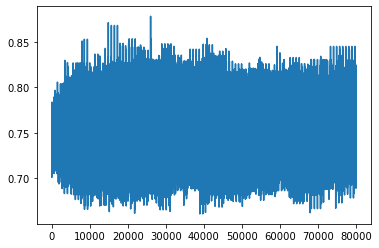

In [15]:
plt.plot(sampler_list['true'][:,2])

In [16]:
sampler_tot = [ sampler_list['true'],sampler_list['BPZ'],sampler_list['flex'], ]

In [17]:
a = len(sampler_list['true'])
middle = np.mean(sampler_list['true'][50000:a-1], axis = 0)
std = np.std(sampler_list['true'][50000:a-1], axis = 0)
range_corner_plot = [(middle[i]- 3*std[i], middle[i]+ 3*std[i]) for i in range(3)]

## Corner plot

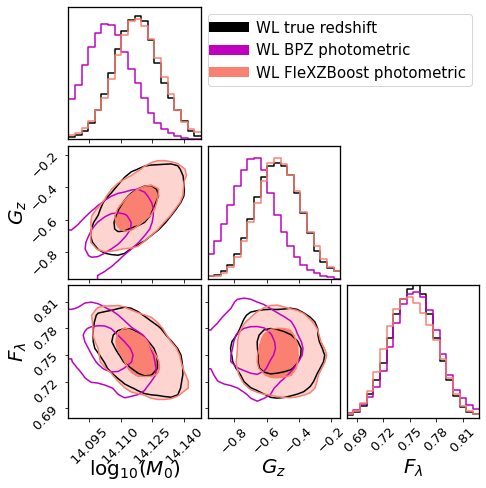

In [18]:
plt.rcParams['axes.linewidth'] = 1.3
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
bins = 20
labels = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
c = ['k','m','salmon','orange','cyan']
fill_contours = [False, False, True,False,  True]
fig, axs = plt.subplots(len(labels), len(labels), figsize = (7,7))
for i, name in enumerate(label_plot):
    axs[0,2].plot([],[], c[i], linewidth = 10, label = label_plot[i])

for i,sample in enumerate(sampler_tot):
    a = len(sample)
    sample_cut = sample[75000:a-1]
    fig = corner.corner(
    sample_cut,
    bins=bins, levels=(sigma1, sigma2),
    range = range_corner_plot,
    truths = None,#fiducial_constraint,
    fig = fig,
    color = c[i],
    smooth1d=True,smooth=True,plot_datapoints=False,
    fill_contours=fill_contours[i], labels = labels,            
    label_kwargs={"fontsize": 20},
    use_math_text=True,
    show_title = True,
    plot_density=False,
    max_n_ticks = 5);
axs[0,2].legend(frameon = True, fontsize = 15)
for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 13)

plt.savefig('effect_photometric_redshift.png', bbox_inches='tight', dpi=300)

In [19]:
a

80000

In [20]:
np.mean(sampler_list['true'][79000:a-1], axis=0)

array([14.11792886, -0.52507778,  0.75406847])

In [21]:
np.std(sampler_list['true'][70000:a-1], axis=0)

array([0.01026917, 0.13624071, 0.02481402])